In [1]:
import sys
import os
import pickle
from tqdm import tqdm
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects'))
import j_utils.munging as mg
from lendingclub.lc_utils import gen_datasets
import seaborn as sns

pd.options.display.max_columns = 999
pd.options.display.max_rows = 60
pd.options.display.max_seq_items = None

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')

# testing
from pandas.testing import assert_frame_equal

In [69]:
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info.fth'))
pmt_hist = pd.read_feather(os.path.join(dpath, 'scaled_pmt_hist.fth'))

for each model: 

Have one overall test set

1) compare top30% of all test in aggregate

2) compare month-by-month top30%

From the test set make 10 bootstrap month by month test sets

3) compare bootstrap month-by-month top30%



# How to decide where to select split date?
# by issue_d, what % of loans have a stat_adj maturity_time/paid greater than .95

In [4]:
issue_d_grouped = eval_loan_info.groupby('issue_d')

In [26]:
doneness = .95
doneness_dict = {}
issuances_dict = {}
for d, group in issue_d_grouped:
    doneness_dict[d] = group.eval('maturity_time_stat_adj >= @doneness or maturity_paid_stat_adj >= @doneness').sum()/len(group)
    issuances_dict[d] = len(group)

(0.78, 1.02)

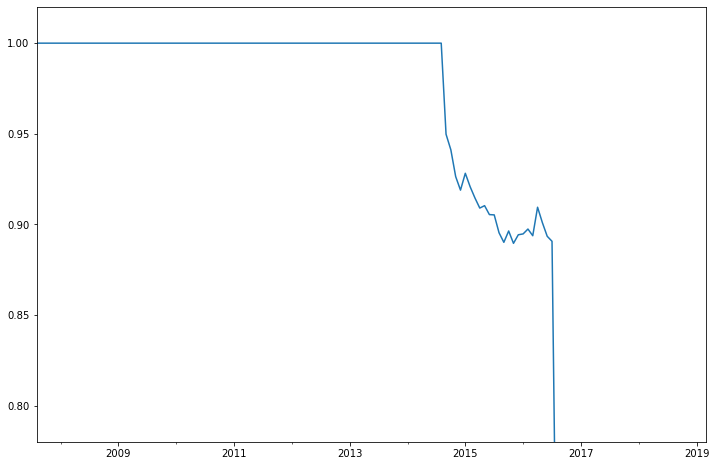

In [27]:
ax = pd.Series(doneness_dict).plot(figsize=(12,8))
ax.set_ylim(.78, 1.02)

In [28]:
doneness_df = pd.DataFrame({'n_issued': issuances_dict, 'pct_doneness_thrsh': doneness_dict})

In [31]:
doneness_df[doneness_df['pct_doneness_thrsh'] > .8]

,n_issued,pct_doneness_thrsh
2007-08-01,21,1.000000
2007-09-01,50,1.000000
2007-10-01,103,1.000000
2007-11-01,112,1.000000
2007-12-01,172,1.000000
2008-01-01,305,1.000000
2008-02-01,306,1.000000
2008-03-01,402,1.000000
2008-04-01,259,1.000000
2008-05-01,115,1.000000


In [32]:
#from 2010-1-1 onward, take out max(90%, n-2000) loans to set aside as train

In [55]:
doneness = .95
train_testable_eval_loan_info = eval_loan_info.query('maturity_time_stat_adj >= @doneness or maturity_paid_stat_adj >= @doneness')
train_testable_ids = train_testable_eval_loan_info['id']
train_testable_loan_info = base_loan_info.query('id in @train_testable_ids')

assert train_testable_eval_loan_info.shape[0] == train_testable_loan_info.shape[0]

train_testable_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_eval_loan_info.fth'))
train_testable_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_loan_info.fth'))

In [76]:
train_testable_eval_loan_info = pd.read_feather(os.path.join(dpath, 'train_testable_eval_loan_info.fth'))
train_testable_loan_info = pd.read_feather(os.path.join(dpath, 'train_testable_loan_info.fth'))

In [77]:
issue_d_g = train_testable_eval_loan_info.groupby('issue_d')

In [101]:
test_ids = []
for date, group in issue_d_g:
    if date >= pd.to_datetime('2010-1-1'):
        test_ids.extend(group.sample(n = min(int(len(group)*.1), 2000))['id'].tolist())

In [107]:
test_eval_loan_info = train_testable_eval_loan_info.query('id in @test_ids')
test_loan_info = train_testable_loan_info.query('id in @test_ids')

train_eval_loan_info = train_testable_eval_loan_info.query('id not in @test_ids')
train_loan_info = train_testable_loan_info.query('id not in @test_ids')

In [126]:
def check_not_same_loans(tr, te, to):
    if len(set(tr['id']).intersection(set(te['id']))) == 0: return True
    else: return False
    
def check_all_loans_accounted(tr, te, to):
    if tr.shape[0] + te.shape[0] == to.shape[0]: return True
    else: return False
    
def check_same_n_instances(df1, df2):
    if df1.shape[0] == df2.shape[0]: return True
    else: return False
    
def check_same_n_cols(df1, df2):
    if df1.shape[1] == df2.shape[1]: return True
    else: return False    
    
def check_train_test_testable(train, test, testable, train1, test1, testable1):
    '''
    First set for loan_info, second set for eval_loan_info
    '''
    print(train.shape, test.shape, testable.shape, train1.shape, test1.shape, testable1.shape)
    assert check_not_same_loans(train, test, testable)
    assert check_all_loans_accounted(train, test , testable)
    assert check_not_same_loans(train1, test1, testable1)
    assert check_all_loans_accounted(train1, test1 , testable1)
    assert check_same_n_instances(train, train1)
    assert check_same_n_instances(test, test1)
    assert check_same_n_instances(testable, testable1)
    assert check_same_n_cols(train, test)
    assert check_same_n_cols(train1, test1)
    return True

In [127]:
check_train_test_testable(train_eval_loan_info, test_eval_loan_info, train_testable_eval_loan_info,
                          train_loan_info, test_loan_info, train_testable_loan_info)

(1354333, 46) (118856, 46) (1473189, 46) (1354333, 103) (118856, 103) (1473189, 103)


True

In [130]:
# save
test_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_eval_loan_info.fth'))
test_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_loan_info.fth'))
train_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_eval_loan_info.fth'))
train_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_loan_info.fth'))

In [148]:
# make 10 bootstrap month-by-month test_loan_infos (and maybe test_eval_loan_infos?)
issue_d_g = test_eval_loan_info.groupby('issue_d')
for i in range(10):
    to_concat = []
    for d, g in issue_d_g:
        to_concat.append(g.sample(len(g), replace=True))
    df = pd.concat(to_concat)
    df.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_eval_loan_info_{0}_bootstrap.fth'.format(i)))

In [150]:
ls {dpath}

base_loan_info.fth*              test_eval_loan_info_0_bootstrap.fth
bsmbm_top30_df.csv               test_eval_loan_info_1_bootstrap.fth
clean_pmt_history_1.fth*         test_eval_loan_info_2_bootstrap.fth
clean_pmt_history_2.fth*         test_eval_loan_info_3_bootstrap.fth
clean_pmt_history_3.fth*         test_eval_loan_info_4_bootstrap.fth
csvs/                            test_eval_loan_info_5_bootstrap.fth
eval_loan_info.fth*              test_eval_loan_info_6_bootstrap.fth
example.py*                      test_eval_loan_info_7_bootstrap.fth
loan_info_api_name_matched.fth*  test_eval_loan_info_8_bootstrap.fth
loan_info.fth*                   test_eval_loan_info_9_bootstrap.fth
mbm_top30_df.csv                 test_eval_loan_info.fth
model_returns_dict.pkl           test_loan_info.fth
npv_roi_df.fth                   train_eval_loan_info.fth
raw_loan_info.fth*               train_loan_info.fth
scaled_pmt_hist.fth*             train_testable_eval_loan_info.fth
strings_loan_info_df.ft